# Referral_Program_AB_Test_Analysis
## Hao Wu
To encourage more referrals, the product team is running an experiment on the iOS app, called “ios_referral_experiment”, that tests adding new links to the referral invite page. The experiment has 3 groups: the “control” group has no new link; the “tab_only” group has a new navigation tab that links to the page; and the “tab_settings” group has both a new navigation tab and a new link in the settings.  What are the results of this experiment, and what would you recommend to the team?

### Description of the data
Included with this exercise is a set of csv files containing data for the following tables.
### split_test_exposures
This table includes all occurrences when a user is exposed to an experiment.
- user_id : unique id for the user
- exposed_time : time when the user was exposed to the experiment
- split_test_name : name of the split test the user was exposed to
- split_test_group : the split test group the user was assigned to
### events
This table includes click and view events in the UI.
- user_id : unique id for the user
- event_time : time when the event occurred
- event_type : the type of event that happened
- “ referral_page_view ”: user views the page for sending referral invites
- “ referrer_page_invite_action ”: users clicks the button to send a referral invite
- event_type_button : the type of button the user clicks for the event


In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 500)
import warnings
warnings.filterwarnings('ignore')
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rc('figure', figsize = (14, 7))

### Part 1 Data process and validation

In this section, I will check the user test split and events datasets. The check will cover:
1. Basic data structure and missing values;

2. Update the variable type and process missing valuues;

3. For user test split dataset, I will also check how users were assigned to the experiment groups.

#### 1.1 User test split table

In [2]:
#load the split test exposres data 
split_test_exposures=pd.read_csv("./Copy of Coinbase Product Analytics Exercise Data/split_test_exposures.csv")
print("Check data types")
print(split_test_exposures.dtypes)
print("\n")
print("Check missing values")
print(split_test_exposures.isnull().any())
print("\n")
print("Print examples")
split_test_exposures.head(3)

Check data types
user_id             object
split_test_name     object
split_test_group    object
exposed_time        object
dtype: object


Check missing values
user_id             False
split_test_name     False
split_test_group    False
exposed_time        False
dtype: bool


Print examples


,user_id,split_test_name,split_test_group,exposed_time
0,650be962eaef1648482b228babb28973,ios_referral_experiment,control,2017-06-29 18:37:01.890000
1,2c35e245e4f8bd07cd4239ee79cc3aed,ios_referral_experiment,tab_settings,2017-06-30 04:38:12.475000
2,bbb4ec386f36f3b1a6ccbaf8d656e940,ios_referral_experiment,tab_settings,2017-06-30 04:47:27.386000


In [5]:
#convert the time variable to datetime format, and extract date to a new variable
split_test_exposures["exposed_time"]=pd.to_datetime(split_test_exposures["exposed_time"])
split_test_exposures["exposed_date"]=split_test_exposures["exposed_time"].dt.date
split_test_exposures.describe(include="all")

,user_id,split_test_name,split_test_group,exposed_time,exposed_date
count,187670,187670,187670,187670,187670
unique,182456,1,3,187656,65
top,c982505bb972a13c9b6aed6d2dca8896,ios_referral_experiment,tab_only,2017-07-04 15:07:18.504000,2017-07-05
freq,2,187670,68424,2,18533
first,NaN,NaN,NaN,2017-06-29 00:49:58.621000,NaN
last,NaN,NaN,NaN,2017-09-01 23:13:36.352000,NaN


In [77]:
split_test_exposures.split_test_group.value_counts()

tab_only        68424
control         59700
tab_settings    59546
Name: split_test_group, dtype: int64

In [13]:
#check how experiment groups were split
split_grp=split_test_exposures.groupby("split_test_group")["exposed_time"].agg(["count","min","max"])                                                
split_grp.columns=["user_count","first_exposure_date","last_exposure_date"]      
split_grp

,user_count,first_exposure_date,last_exposure_date
split_test_group,,,
control,59700,2017-06-29 00:51:25.296,2017-07-27 23:34:57.844
tab_only,68424,2017-06-29 00:53:32.933,2017-09-01 23:13:36.352
tab_settings,59546,2017-06-29 00:49:58.621,2017-07-27 23:35:00.168


**Key takeaways**:

- First, Based on the summary of the data, users started getting exposed to the experiment from 6/29/2019 through 9/1/2019. The table is not unique at user_id level, and there are 5214(~3%) users showing up at least two times. In this experiment, the unit of diversion is supposed to be a user, because it makes sense to keep the user experience consistent.

- Second, users in "tab_only" are more than the other two groups by ~15%. After 7/27/2017, no user was exposed to the "control" or "tab_setting" groups, but "tab_only" group had users exposed over 7/28/2017 to 9/1/2019. This will introduce bias in the performance.

**Next Step**

I will figure out if the duplicate users were assigned into different groups. Or they were assigned in the identical group but the system marked them twice due to technical issues. Will also look into the users who were exposed to "tab_only" groups after 07/27/2019. 

In [14]:
#check if the split table is unique at the user_id and split_test_group level
len(split_test_exposures)==len(split_test_exposures.drop_duplicates(subset=["user_id","split_test_group"]))

True

The split test table is unique at the user_id and split_test_group, which means for some users, they were assigned to different groups. Next step, I will first mark those users, and check the experiment groups were split with and without them. 

In [15]:
#create a key to mark users have multiple assignments
cnt_user_msk=split_test_exposures.groupby(["user_id"]).cumcount()+1
dup_users=split_test_exposures.loc[cnt_user_msk>1,"user_id"].unique()
len(dup_users)

5214

In [17]:
#how the second group of dupelicated users were assigned
split_grp_2=split_test_exposures.loc[cnt_user_msk>=2].groupby("split_test_group")["exposed_time"].agg(["count","min","max"])
split_grp_2.columns=["user_count","first_exposure_date","last_exposure_date"]      
split_grp_2


,user_count,first_exposure_date,last_exposure_date
split_test_group,,,
tab_only,5214,2017-07-27 23:38:46.729,2017-09-01 21:43:56.801


All the double-assigned users got exposed to the second group which is "tab_only" from 07/27/2019. It might be caused from the technical issue. It's safe to drop all of them to avoid introducing biases.

In [18]:
#Check users who were assigned tab_only after 07/27/2019 but not double assigned
time_msk=split_test_exposures.exposed_time>pd.Timestamp("2017-07-28")
dupe_msk=split_test_exposures.user_id.isin(dup_users)
print(sum(time_msk&~dupe_msk), "\t" ,sum(time_msk&~dupe_msk)/len(split_test_exposures))


3719 	 0.019816699525763308


There are 3719 users (~2%) users assigned after 7/27/2017. To avoid introducing factors that likely impact on the test results, those users have to be dropped

In [23]:
#drop users who were assigned into two different groups and were assigned to "tab_only" after 7/27/2019
split_grp_3=split_test_exposures.loc[~time_msk&~dupe_msk].groupby("split_test_group")["exposed_time"].agg(["count","min","max"])
split_grp_3.columns=["user_count","first_exposure_date","last_exposure_date"]      
split_grp_3

,user_count,first_exposure_date,last_exposure_date
split_test_group,,,
control,57105,2017-06-29 00:51:25.296,2017-07-27 23:34:57.844
tab_only,59491,2017-06-29 00:53:32.933,2017-07-27 23:59:33.000
tab_settings,56927,2017-06-29 00:49:58.621,2017-07-27 23:35:00.168


In [24]:
#percent of data kept 
user_split=split_test_exposures.loc[~time_msk&~dupe_msk]
len(user_split)/len(split_test_exposures)

0.9246176799701604

**~8% users are dropped from the analysis. Although the % difference between the largest group, tab_only, and tab_settings is ~4%, it's acceptable in the experiment setting.**

#### 1.2 Events table

In [25]:
#read the events table
events=pd.read_csv("./Copy of Coinbase Product Analytics Exercise Data/events.csv")
print("Check data types")
print(events.dtypes)
print("\n")
print("Check missing values")
print(events.isnull().any())
print("Print examples")
events.head(3)

Check data types
user_id              object
event_type           object
platform             object
event_type_button    object
event_time           object
dtype: object


Check missing values
user_id              False
event_type           False
platform             False
event_type_button     True
event_time           False
dtype: bool
Print examples


,user_id,event_type,platform,event_type_button,event_time
0,85131fd246b809cabc03b232b3c5e257,referrer_page_viewed,iOS,NaN,2017-06-02 00:02:34.585000
1,70c20ae3f1ec0da5afcd5c47fc922a6c,referrer_page_viewed,Web,NaN,2017-06-02 02:25:43.348000
2,70c20ae3f1ec0da5afcd5c47fc922a6c,referrer_page_invite_action,Web,link,2017-06-02 02:25:47.397000


There are missing values in "event_type_button", will check it. 

In [26]:
#convert the time variable to datetime format, and extract date to a new variable
events["event_time"]=pd.to_datetime(events["event_time"])
events["event_date"]=pd.to_datetime(events["event_time"]).dt.date
events.describe(include="all")

,user_id,event_type,platform,event_type_button,event_time,event_date
count,455519,455519,455519,96679,455519,455519
unique,140568,2,2,10,455494,92
top,32f22515376d051a9cbc3ba4e378e75b,referrer_page_viewed,iOS,email,2017-06-05 12:32:02.423000,2017-08-18
freq,29267,358840,297563,48537,2,15299
first,NaN,NaN,NaN,NaN,2017-06-02 00:00:21.336000,NaN
last,NaN,NaN,NaN,NaN,2017-09-01 23:59:14.475000,NaN


In [28]:
#check the values in the "event_type_button"
events.groupby("event_type")["event_type_button"].value_counts(dropna=False)

event_type                   event_type_button
referrer_page_invite_action  email                 48537
                             link                  21550
                             messenger              6700
                             facebook               5059
                             Link                   3915
                             SMS                    3451
                             ShareDialog            2250
                             twitter                2140
                             Email                  1701
                             WhatsApp               1376
referrer_page_viewed         NaN                  358840
Name: event_type_button, dtype: int64

Variable "event_type_button" was attributed to "NaN" when "event_type" is "referrer_page_viewed". No extra process is neccesary. Need convert all values in "event_type_button" to lower case. 

In [29]:
events["event_type_button"]=events["event_type_button"].str.lower()
print(events["event_type_button"].value_counts())
print("\n")
#split data into ios and web events
ios_events=events.loc[events["platform"]=="iOS"]
web_events=events.loc[events["platform"]=="Web"]
print(ios_events.shape)
print(web_events.shape)

email          50238
link           25465
messenger       6700
facebook        5059
sms             3451
sharedialog     2250
twitter         2140
whatsapp        1376
Name: event_type_button, dtype: int64


(297563, 6)
(157956, 6)


### Part 2 Define and calculate relavant metrics and evaluate the results

To measure the impacts from this new feature, following metrics wil be calculated:

- **Click probablity:**  percent of users who viewed referrer page, calculated by count of users who visit referrer page devided by total user count in the group. For control group, the percent of users visiting referrer page will be calculated. 

 
- **Invite send rate:**     percent of users who send out at least one invite, calculated by count of users send out at lease one invite devided by total user count in the group.t For the control group, the percent of users sending out invites will be calculated. 

 
- **Invite to click ratio:** ratio of count of invites to count of clicks, calculated by total invite count devided by total click count.

The referree sign-up table is provided, but there's no direct link to map the referrees and referrers to the "invite sent" events. Therefore if the invites bring new users will not be evaluated. 

**To compare the test groups against control group, the two-sample prortion tests will be applied.** The p values from the tests, the differences ($p_{test}-p_{control}$), and confidence interval of differences will be calulated. SInce two treats are in the experiments, the significant level is adjusted to 97.5% ($1-\frac{\alpha}{2}, \alpha=0.05$), i.e. test will be treated as significant if **p value<0.025.**

**The overall metrics** and test results will be calculated. Since users started getting assigned to the experiment in different dates,  **metrics will also be calculated and tested by cohort** which is devided by the exposure days of experiment. 

In [30]:
#merge the user split table and event table to flag the users in the event table 
event_exp_join=ios_events.merge(user_split,left_on=["user_id"],
             right_on=["user_id"],how="inner")
print(len(event_exp_join),"\t", len(event_exp_join)/len(ios_events))
#calculate the days between experiment exposed date and event date
event_exp_join["exposure_days"]=(event_exp_join.event_date-event_exp_join.exposed_date).astype('timedelta64[D]')
#keep the events happening after users exposed to the expetiment
event_exp_join=event_exp_join.loc[event_exp_join["exposure_days"]>=0]
print(len(event_exp_join),"\t", len(event_exp_join)/len(ios_events))


100736 	 0.3385367132338362
100669 	 0.3383115508312525


In [115]:
#define a ictionary, including names of metrics as keys, and list of denominators and numeritors as values
metric_dict={"view_page_prob":["user_count","view_page_user_count"],
             "invite_send_rate":["user_count","referrer_user_count"],
             "invite_click_rate":["view_page_count","referrer_invite_count"]}

#define help functions to calculate the metrics, and apply the proportion test between the treatment groups against the control group
def mectric_cal(user_df,event_df,level):
    '''
    This function will calculate the metrics, output the metrics as requested level.
    Arguments:
    user_df: dataFrame user count at specific level
    even_df: dataFrameevent table including the user group and exposure day information
    level: string or list indicating the level metrics will be aggregated to
    Returns:
    smry -- dataFrame metrics of three groups at speficit level
   
    '''
    #calculate the click probability 
    smry=user_df.join(event_df.loc[event_df["event_type"]=="referrer_page_viewed"].groupby(level)["user_id"].\
                     agg(["nunique","count"]))
    smry.rename(columns={"nunique": "view_page_user_count", "count": "view_page_count"},inplace=True)
    smry["view_page_prob"]=smry["view_page_user_count"]/smry["user_count"]
    
    #calculate the invite_send_rate and ratio of invite count to click count
    smry=smry.join(event_df.loc[event_df["event_type"]=="referrer_page_invite_action"].\
                           groupby(level)["user_id"].agg(["nunique","count"]))
                                             
    smry.rename(columns={"nunique": "referrer_user_count", "count": "referrer_invite_count"},inplace=True)
    smry["view_page_prob"].fillna(0,inplace=True)
    smry["referrer_user_count"].fillna(0,inplace=True)
    smry["referrer_invite_count"].fillna(0,inplace=True)
    smry["invite_send_rate"]=smry["referrer_user_count"]/smry["user_count"]
    
    smry["invite_click_rate"]=smry["referrer_invite_count"]/smry["view_page_count"]                                                                       
       
    return smry

def test_result(df,metric_dict=metric_dict):
    '''
    This function caculate the p values of proportion test, differences, and confidence interval of differences.
    Arguments:
    df: dataFrame metric table
    metric_dict-- Dictionary, including names of metrics as keys, and list of denominators and numeritors as values
 
    Returns:
    result -- dataFrame include all statistical values. 
    
    '''
    #import packages
    from statsmodels.stats.proportion import proportions_ztest
    import scipy.stats as st
    #define result table
    result=pd.DataFrame(columns=["metric","split_test_group","difference","p_value","CI_low","CI_upp"])
    
    for metric in metric_dict.keys():
        counts=metric_dict[metric]
        for group in ["tab_only","tab_settings"]:
            msk=df.index.isin(["control",group])
        #get the sample size
            nobs=   np.array(df.loc[msk,counts[0]])
        #get the counts from the table
            ncounts=np.array(df.loc[msk,counts[1]])
        #calculate p value and zstats
            zstats, p_ = proportions_ztest(ncounts, nobs)
            thru_rate=np.array(df.loc[msk,metric])
            #calculate difference between treatment and control
            diff_rate=thru_rate[1]-thru_rate[0]
            #calculate the s.e. via z statistics and multiply by 97.5% critical value from normal distribution
            m=abs(diff_rate/zstats)*st.norm.ppf(.975)
            result=result.append({"metric":metric,
                                  "split_test_group":group,
                                  "difference":diff_rate,
                                   "p_value":p_,
                                   "CI_low":diff_rate-m,
                                   "CI_upp":diff_rate+m},ignore_index=True)

    return result

### 2.1 Check overall metrics 

In [116]:
#caculate the overall metrics
#all_user_df=user_split.groupby("split_test_group")["user_id"].nunique().to_frame(name='user_count')
all_user_df
overall=mectric_cal(all_user_df,event_exp_join,"split_test_group")
overall[metric_dict.keys()]


,view_page_prob,invite_send_rate,invite_click_rate
split_test_group,,,
control,0.148533,0.007583,0.040844
tab_only,0.247987,0.015666,0.043933
tab_settings,0.231015,0.014949,0.049261


In [117]:
# Proportion test results between test groups and control group
test_result(overall)

,metric,split_test_group,difference,p_value,CI_low,CI_upp
0,view_page_prob,tab_only,0.099454,0.000000e+00,0.094867,0.104040
1,view_page_prob,tab_settings,0.082482,2.397150e-276,0.077931,0.087033
2,invite_send_rate,tab_only,0.008084,1.140408e-37,0.006849,0.009319
3,invite_send_rate,tab_settings,0.007366,4.514752e-32,0.006142,0.008591
4,invite_click_rate,tab_only,0.003088,8.142417e-02,-0.000385,0.006562
5,invite_click_rate,tab_settings,0.008417,8.628359e-06,0.004709,0.012125


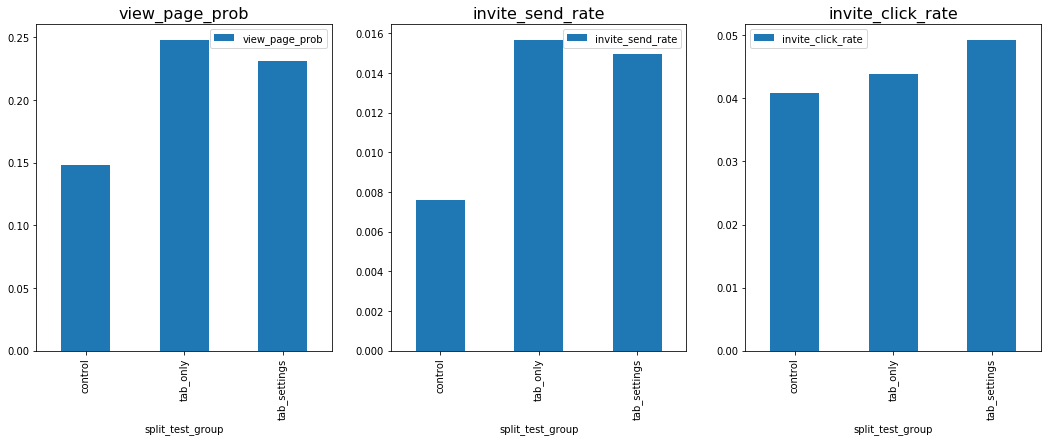

In [118]:
#Visualization of overall metrics
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
for i in range(3):
    metric=list(metric_dict.keys())[i]
    overall.plot(y=metric,ax=ax[i],kind="bar")
    ax[i].set_title(metric, fontsize=16)

**Findings:**

- Overall, the new-added link brought more users to the referrer page, and “tab_only” (difference ~9,9%) had better performance than the “tab_settings”( difference 8.2%). 
- There are significant increases of percent of users sending out invites in the two treatment groups. 
- All tests are significant at 97.5% level.
- In terms of the ratios of invites to clicks, the test groups are very close to the control group. The confidence intervals of differences are very close 0, and “tab_only” group includes the 0.

**Next step:**
Check the metrics calculated by exposure days of experiment, to observe how the metrics change over time. The proportion test comparing test groups against control group will be applied as well. 

### 2.2 Check Metrics by Cohort


In [119]:
#Create user counts by exposure days and split group
user_split["max_exposure_day"]=(max(event_exp_join.event_date)-user_split["exposed_date"]).astype('timedelta64[D]')
temp=user_split.groupby(["max_exposure_day","split_test_group"],as_index=False)["user_id"].agg({"user_count":"nunique"})                                          
user_cohort_df=pd.DataFrame()
for i in range(65):
    grp=temp.loc[temp["max_exposure_day"]>=i].\
    groupby("split_test_group",as_index=False).agg({"user_count":"sum"})
    grp["exposure_days"]=i
    user_cohort_df=user_cohort_df.append(grp)
del temp
user_cohort_df.set_index(["exposure_days","split_test_group"],inplace=True) 

#Calculate the cohort metrics
cohort=mectric_cal(user_cohort_df,event_exp_join,["exposure_days","split_test_group"])
cohort[metric_dict.keys()].head(3)

view_page_prob  invite_send_rate  \
exposure_days split_test_group                                     
0             control                 0.000018          0.000000   
              tab_only                0.055975          0.002488   
              tab_settings            0.053613          0.002723   

                                invite_click_rate  
exposure_days split_test_group                     
0             control                    0.000000  
              tab_only                   0.044741  
              tab_settings               0.063998

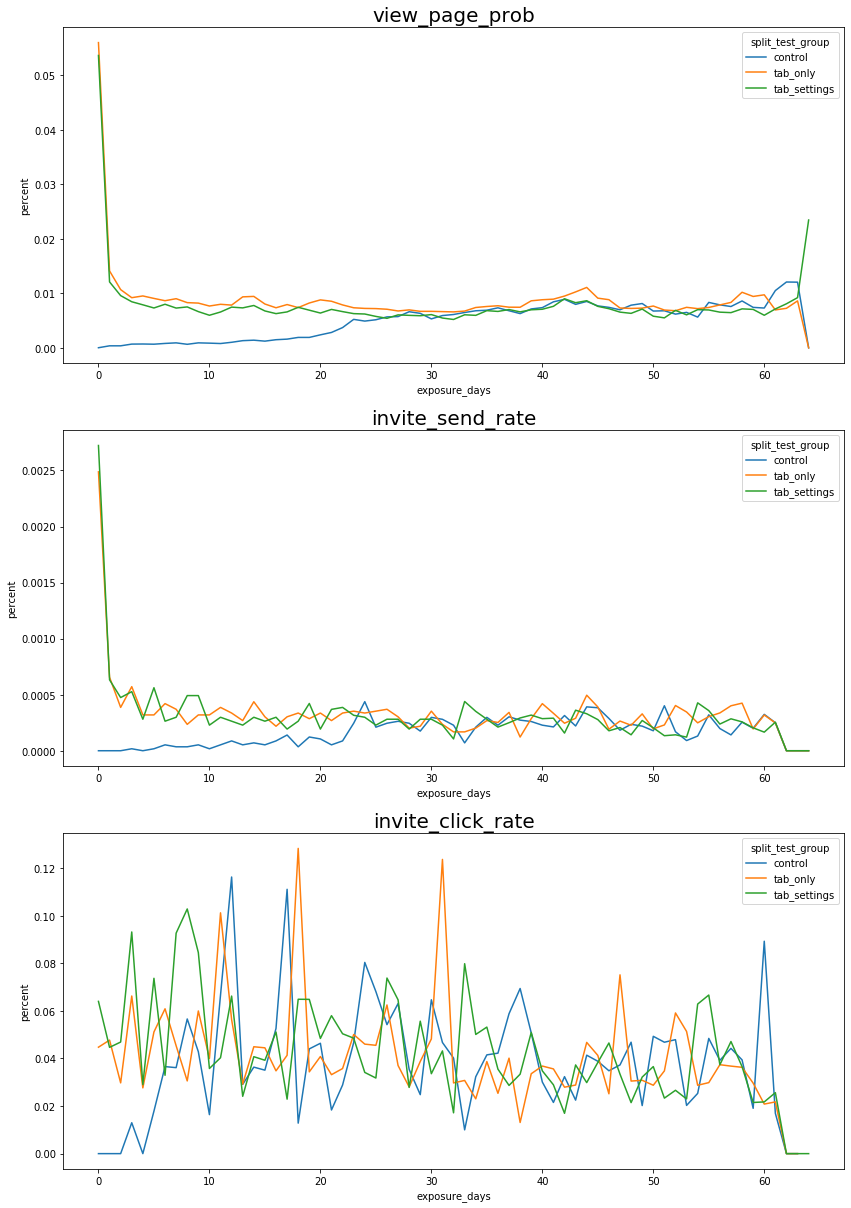

In [120]:
#Visualization of metrics over exposure days
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(14, 21))
for i in range(3):
    metric=list(metric_dict.keys())[i]
    cohort.unstack().plot(y=metric,ax=ax[i])
    ax[i].set_title(metric, fontsize=20)
    ax[i].set_ylabel('percent')
    cohort[metric_dict.keys()]
 

In [121]:
#perform proportion test for each cohort
cohort_test=cohort.reset_index(level="exposure_days").groupby("exposure_days").apply(test_result)
cohort_test.reset_index("exposure_days",inplace=True)
cohort_test.head(6)

,exposure_days,metric,split_test_group,difference,p_value,CI_low,CI_upp
0,0,view_page_prob,tab_only,0.055957,0.000000e+00,0.054045,0.057870
1,0,view_page_prob,tab_settings,0.053595,0.000000e+00,0.051721,0.055469
2,0,invite_send_rate,tab_only,0.002488,8.597437e-33,0.002079,0.002897
3,0,invite_send_rate,tab_settings,0.002723,9.863601e-36,0.002295,0.003150
4,0,invite_click_rate,tab_only,0.044741,8.286637e-01,-0.360452,0.449934
5,0,invite_click_rate,tab_settings,0.063998,7.937200e-01,-0.415706,0.543703


In [ ]:
#check the p values above 0.025. 
p_msk=cohort_test.p_value>0.025
cohort_test.loc[p_msk,].groupby(["metric","split_test_group"]).exposure_days.describe()

In [ ]:
#check if the differences and confidence intervals of difference close to 0
ci_msk=(np.sign(cohort_test.CI_upp) != np.sign(cohort_test.CI_low)) | (cohort_test.difference<=0)
cohort_test.loc[ci_msk,].groupby(["metric","split_test_group"]).exposure_days.describe()

In [ ]:
#Visualization of differenes over exposure days
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 21))
for i in range(3):
    metric=list(metric_dict.keys())[i]
    for grp,df in cohort_test.groupby("split_test_group"):    
        y=df.loc[df.metric==metric,"difference"]
        x=df.loc[df.metric==metric,"exposure_days"]
        ax[i].plot(x,y,label=grp)
    ax[i].set_title(metric+"_differences", fontsize=20)
    ax[i].axhline(y=0,color="red",ls="--")
    ax[i].legend(loc = 'best')

**Findings:**

Observe how the metrics change over time.

- The click_thru_prob and invite_send_rate increase dramatically in the first three days.

- After 10 days, both test groups still win, but they are getting closer and closer.

- After 25 days, the differences of click_thru_prob between test groups and the control group are not significant. Although the “tab_only” group win over the control most time, the differences are very small. The invite_send_rate are fluctuating around 0, and no significant winner after 25 days.

- For the invite click rates, they change dramatically over day, no pattern can be identified.

**The proportion tests validate the findings.**

- Tests of click-through probabilities are significantly higher in the first 25 days and 28 days for tab_only and tab_setting groups respectively;

- Click sent rate are significantly higher in the first 16 and 17 days for tab_only and tab_setting groups.

- Differences of invite click rates are not significant in most exposure days.


### Part 3 Conclusion and recommendation

Overall, the new-added link of the referrer page is helpful bringing more users to visit the page, and leading more users to send out invites. However, as the test goes on, the differences between the tests and control groups are getting closer. After 30 days we don’t see any significant differences. 

The temporary lift in metrics partly is caused by the novelty effect. The new link brings a lot of attention and leads users to review the page and send out invites. With time, the lift disappears because the change is no longer novelty. 

Another reason to explain the lift will not last in the long term is,  the count of the referral invites from one user is decreasing over time. Users have limited numbers of potential referees, and it will take long time to make new friends and get more new referees. If users have invited all potential referees, they will not land the referrer page in a long time. 

If in the short term, users bring more new users via the referral program, it’s still a win for the company in the long term. Therefore I would recommend adding the the navigation tab that links to the page to the iOS platform.

Based on the AB test results:

- Overall, "tab_only" group had slightly higher proportions of users visiting the referrer page and sending invites than the "tab_setting" group. 

- By cohort, in the click through probablity, the differences between the "tab_only" group and control group are slightly above 0 after 30 days. 

Even though the performance differences between the two test groups are very minor, the "tab_only" still is a better feature to roll out. 

In the meantime, some **education prompt and referral program campaign** should be added to remind current users and educate new uers. For example, pop-up app banners or campaign emails. 

In conclusion, to encourage more referrals in the long term, adding the tab to direct users to the referrer page and using periodical promp or campaigns get more attentions will be helpful and practical. 